## O Problema

-- Objetivo do Problema:

    -- 1.0. Previsão do primeiro destino que um novo usuário irá escolher
    
    -- Porque?
    
        -- Qual o tipo de modelo de negócio do Airbnb?
        
            -- Marketplace - Demanda x Oferta (Conectar pessoas que oferecem acomodação, com pessoas que estão procurando acomodação)
            
            -- Oferta (pessoas oferecendo acomodação)
            
                -- Métricas:
                
                    -- Tamanho do portifólio (país x cidade)
                    
                    -- Diversidade/Densidade de portifólio (Dentro de um país existem acomodações em todas as cidades ou só em algumas)
                    
                    -- Preço médio
                    
                -- Demanda (pessoas procurando acomodação):
                
                    -- Número de usuários
                    
                    -- Quanto o usuário gasta na plataforma
                    
                    -- Custo por cliente
                    
                     Receita = (Preço médio de comissão * Número de clientes) - Custo por cliente

-- Proposta da solução

    -- Modelo de previsão do primeiro destino de um novo usuário.
    
    -- Predições armazenadas em uma tabela no banco de dados.
    
    -- API
    
        -- Input: usuário e suas características.
        
        -- Output: usuário e suas características com a predição do destino.

# <font color=red> Ciclo-01 </font>

## 0.0. Importação

### 0.1. Funções

In [125]:
import pandas as pd
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt

# Rede Neural
from sklearn import model_selection as ms
from keras import models as ml
from keras import layers as l

### 0.2. Carregando Dados

In [16]:
df_raw_users = pd.read_csv('dataset/training_users.csv', low_memory=True) #low_memory: carregar os dados em batchs
df_raw_users.shape

(213451, 16)

In [17]:
df_raw_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
df_raw_sessions.shape

(10567737, 6)

In [13]:
#df_sessions[['action','user_id']].groupby('action').count()
#df_sessions[['user_id','action']].value_counts()

## 1.0. Descrição dos Dados

In [71]:
df1_users = df_raw_users.copy()
df1_sessions = df_raw_sessions.copy()

In [23]:
print(f'Número de linhas df_users: {df1_users.shape[0]}')
print(f'Número de colunas df_users : {df1_users.shape[1]}')

Número de linhas df_users: 213451
Número de colunas df_users : 16


In [24]:
print(f'Número de linhas df_sessions: {df1_sessions.shape[0]}')
print(f'Número de colunas df_sessions: {df1_sessions.shape[1]}')

Número de linhas df_sessions: 10567737
Número de colunas df_sessions: 6


In [25]:
df1_users.sample(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
132561,1ghm9ds1aw,2013-12-15,20131215020204,2013-12-26,-unknown-,105.0,basic,25,en,direct,direct,omg,iOS,Windows Desktop,Chrome,US
130152,4ktaan264t,2013-12-05,20131205224141,2014-09-07,FEMALE,25.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US
157521,umnqfbvgui,2014-02-27,20140227070919,NaN,FEMALE,22.0,facebook,0,en,seo,google,linked,Web,Mac Desktop,Chrome,NDF
75812,3p9e6hwwfo,2013-05-08,20130508224223,NaN,MALE,23.0,facebook,0,en,direct,direct,linked,Web,Mac Desktop,Firefox,NDF
212438,7pgblxvgrm,2014-06-29,20140629024824,NaN,-unknown-,NaN,basic,0,en,seo,google,linked,Web,Windows Desktop,Chrome,NDF


In [26]:
df1_sessions.sample(5)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
311271,nq0c3g76js,show,NaN,NaN,Windows Desktop,41.0
852040,zfwe9ax4e1,personalize,data,wishlist_content_update,Mac Desktop,3492.0
3398878,wcth2svwgs,similar_listings,data,similar_listings,Windows Desktop,878.0
6490370,y4fz9ytpz8,show,view,p3,Tablet,47.0
5734051,pdjjcdzgwa,show,view,p3,Windows Desktop,674.0


### 1.1. Tipo de Dados

In [49]:
df1_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [50]:
df1_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

### 1.2. Verificando NA

In [55]:
df1_users.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [56]:
df1_sessions.isna().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [72]:
# removendo valores nulos completamente
df1_users = df1_users.dropna()
df1_users.shape

(68171, 16)

### 1.3. Alterando Tipo de Dados

In [73]:
# date_account_created
df1_users['date_account_created'] = pd.to_datetime(df1_users['date_account_created'])

# timestamp_first_active
df1_users['timestamp_first_active'] = pd.to_datetime(df1_users['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1_users['date_first_booking'] = pd.to_datetime(df1_users['date_first_booking'])

# gender

# age
df1_users['age'] = df1_users['age'].astype(int)

### 1.4. Verificando Balanceamento de Dados

In [68]:
df1_users['country_destination'].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [51]:
#df1_sessions[df1_sessions['user_id'].isna()].sample(5)
#df1_sessions.info()
#df1_sessions[df1_sessions['user_id'].isna()].sample(5)

## 2.0. Filtrando os Dados

In [74]:
df2_users = df1_users.copy()

### 2.1. Filtrando Linhas

### 2.2. Selecionando Colunas

## 3.0. Preparação dos Dados

In [103]:
df3_users = df2_users.copy()

In [106]:
# variáveis dummy
df3_users_dummy = pd.get_dummies(df3_users.drop(['id','country_destination'], axis=1))

# juntar id e country destination
df3_users = pd.concat([df3_users[['id','country_destination']], df3_users_dummy], axis=1)

## 4.0. Feature Selection

In [108]:
cols_drop = ['date_account_created','timestamp_first_active','date_first_booking'] #dados originais
df4_users = df3_users.drop(cols_drop, axis=1)

## 5.0. Modelos de Machine Learning - Neural Network (Multi-Layer Perceptron)

In [109]:
X = df4_users.drop('country_destination', axis=1)
y = df4_users['country_destination'].copy()

In [110]:
# Separando dataset em treino e teste
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [111]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

In [112]:
# transformando valores da classificação para RN
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [115]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation = 'relu'))
model.add(l.Dense(11, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

# train model
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100


2023-01-17 21:20:39.083292: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 48864256 exceeds 10% of free system memory.


1705/1705 [==============================] - 2s 1ms/step - loss: 1.3130 - accuracy: 0.7068
Epoch 2/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2810 - accuracy: 0.7076
Epoch 3/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2349 - accuracy: 0.7081
Epoch 4/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2148 - accuracy: 0.7084
Epoch 5/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2000 - accuracy: 0.7086
Epoch 6/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1858 - accuracy: 0.7085
Epoch 7/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1644 - accuracy: 0.7086
Epoch 8/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1622 - accuracy: 0.7084
Epoch 9/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1506 - accuracy: 0.7087
Epoch 10/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1437 

Epoch 80/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0975 - accuracy: 0.7120
Epoch 81/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0975 - accuracy: 0.7119
Epoch 82/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0977 - accuracy: 0.7126
Epoch 83/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0975 - accuracy: 0.7123
Epoch 84/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0971 - accuracy: 0.7121
Epoch 85/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0966 - accuracy: 0.7122
Epoch 86/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0966 - accuracy: 0.7122
Epoch 87/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0963 - accuracy: 0.7124
Epoch 88/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0970 - accuracy: 0.7124
Epoch 89/100
1705/1705 [==============================] - 2s 1ms

## 5.0. NN Performance

In [119]:
# predição
pred_nn = model.predict(x_test)

# inverter valores dummy para o resultado da predição
yhat_nn = ohe.inverse_transform(pred_nn)

# preparar predição
yhat_nn = yhat_nn.reshape(1, -1)[0]
y_test_nn = y_test.to_numpy()

427/427 [==============================] - 0s 760us/step


Accuracy: 0.7034836817015034


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

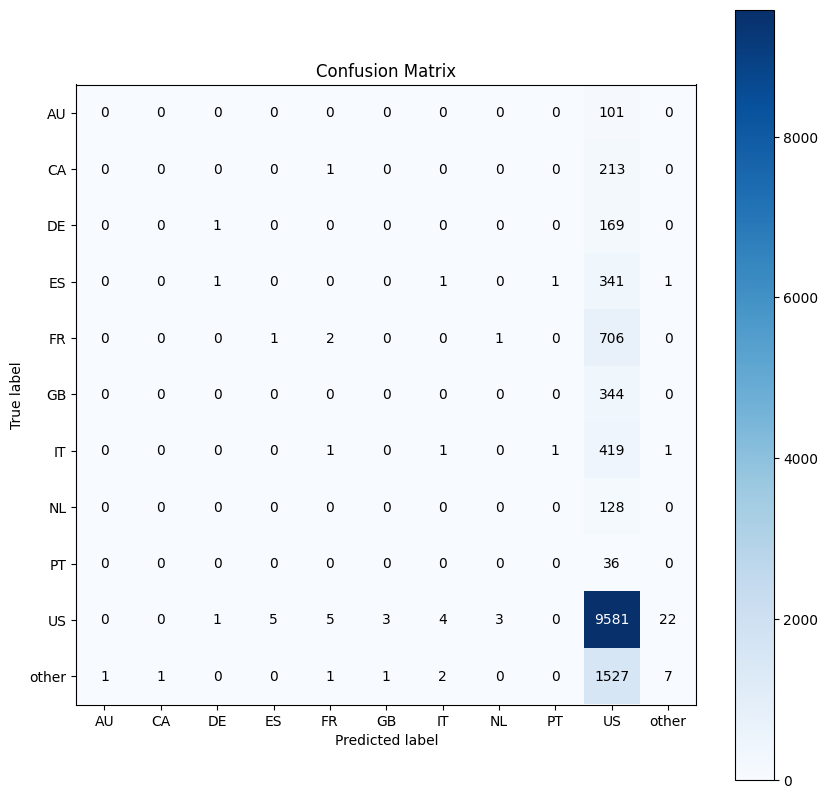

In [128]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(10,10))